# RNN
코스피 주가 예측을 위한 RNN모델
1. 여러 feature중 종가를 ground truth로 설정
2. sliding window 방식으로 데이터를 전처리 (window = 5)
3. RNN 모델 생성 (layer = 2, hidden_size = 8)
4. training
5. plotting

본 내용은 https://data-science-hi.tistory.com/190 을 바탕으로 작성

In [117]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [26]:
df = pd.read_csv('./data/kospi.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [30]:
# 정규화
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Volume']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,2206.199951,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,2204.850098,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,2203.459961,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,2203.419922,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,2177.050049,0.197057


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431 entries, 0 to 430
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       431 non-null    object 
 1   Open       431 non-null    float64
 2   High       431 non-null    float64
 3   Low        431 non-null    float64
 4   Close      431 non-null    float64
 5   Adj Close  431 non-null    float64
 6   Volume     431 non-null    float64
dtypes: float64(6), object(1)
memory usage: 23.7+ KB


In [42]:
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df[['Close']].values

X

array([[0.72289794, 0.73235114, 0.74552494, 0.24211269],
       [0.76305769, 0.75006898, 0.76908866, 0.27477069],
       [0.75189373, 0.74571401, 0.76928042, 0.24160871],
       ...,
       [0.86633761, 0.88027663, 0.88544287, 0.35540772],
       [0.85426636, 0.86403517, 0.86872415, 0.25657696],
       [0.86162744, 0.85344481, 0.83542819, 0.40096008]])

In [50]:
def seq_data(x, y, seq_len):
    x_seq = []
    y_seq = []
    # sliding window 방법으로 겹치게 데이터를 생성!
    for i in range(len(x) - seq_len):
        x_seq.append(x[i: i+seq_len])
        y_seq.append(y[i+seq_len])
        
    return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq).view([-1, 1])

split = 200
seq_len = 5
x_seq, y_seq = seq_data(X, Y, seq_len)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]


print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([200, 5, 4]) torch.Size([200, 1])
torch.Size([226, 5, 4]) torch.Size([226, 1])


In [57]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

# 시계열 데이터이므로 shuffle을 할 때 조심!
batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

https://wegonnamakeit.tistory.com/52
https://coding-yoon.tistory.com/55

In [61]:
input_size = x_seq.size(2) # 4개의 특징
num_layers = 2 # RNN 위로 몇 개 쌓을지. 기본적으로는 1임
hidden_size = 8 

# seq_len : input data의 길이
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, seq_len, num_layers):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size*seq_len, 1), nn.Sigmoid())
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size) # hidden : [num_layer, batch_size, hidden_size] 
        out, _ = self.rnn(x, h0)
        out = out.reshape(out.shape[0], -1)
        out = self.fc(out)
        return out
        

In [108]:
model = VanillaRNN(input_size = input_size,
                  hidden_size = hidden_size,
                  seq_len = seq_len,
                  num_layers = num_layers)

criterion = nn.MSELoss()
lr = 1e-3  # 3
epochs = 1000 # 500
optimizer = optim.Adam(model.parameters(), lr = lr)

In [109]:
loss_graph = []
n = len(train_loader)

for epoch in range(epochs):
    running_loss = 0.0
    for data in train_loader:
        seq, target = data # 배치 데이터
        out = model(seq)
        loss = criterion(out, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_graph.append(running_loss / n) # 평균 loss를 넣어줌
    if epoch % 10 == 0:
        print('[epoch: {%d}] loss: %.4f' % (epoch, running_loss / n))

[epoch: {0}] loss: 0.0166
[epoch: {10}] loss: 0.0064
[epoch: {20}] loss: 0.0062
[epoch: {30}] loss: 0.0059
[epoch: {40}] loss: 0.0054
[epoch: {50}] loss: 0.0048
[epoch: {60}] loss: 0.0038
[epoch: {70}] loss: 0.0023
[epoch: {80}] loss: 0.0012
[epoch: {90}] loss: 0.0011
[epoch: {100}] loss: 0.0011
[epoch: {110}] loss: 0.0010
[epoch: {120}] loss: 0.0010
[epoch: {130}] loss: 0.0010
[epoch: {140}] loss: 0.0010
[epoch: {150}] loss: 0.0010
[epoch: {160}] loss: 0.0009
[epoch: {170}] loss: 0.0009
[epoch: {180}] loss: 0.0009
[epoch: {190}] loss: 0.0009
[epoch: {200}] loss: 0.0009
[epoch: {210}] loss: 0.0009
[epoch: {220}] loss: 0.0009
[epoch: {230}] loss: 0.0008
[epoch: {240}] loss: 0.0008
[epoch: {250}] loss: 0.0008
[epoch: {260}] loss: 0.0008
[epoch: {270}] loss: 0.0008
[epoch: {280}] loss: 0.0008
[epoch: {290}] loss: 0.0007
[epoch: {300}] loss: 0.0007
[epoch: {310}] loss: 0.0007
[epoch: {320}] loss: 0.0007
[epoch: {330}] loss: 0.0007
[epoch: {340}] loss: 0.0007
[epoch: {350}] loss: 0.0006
[ep

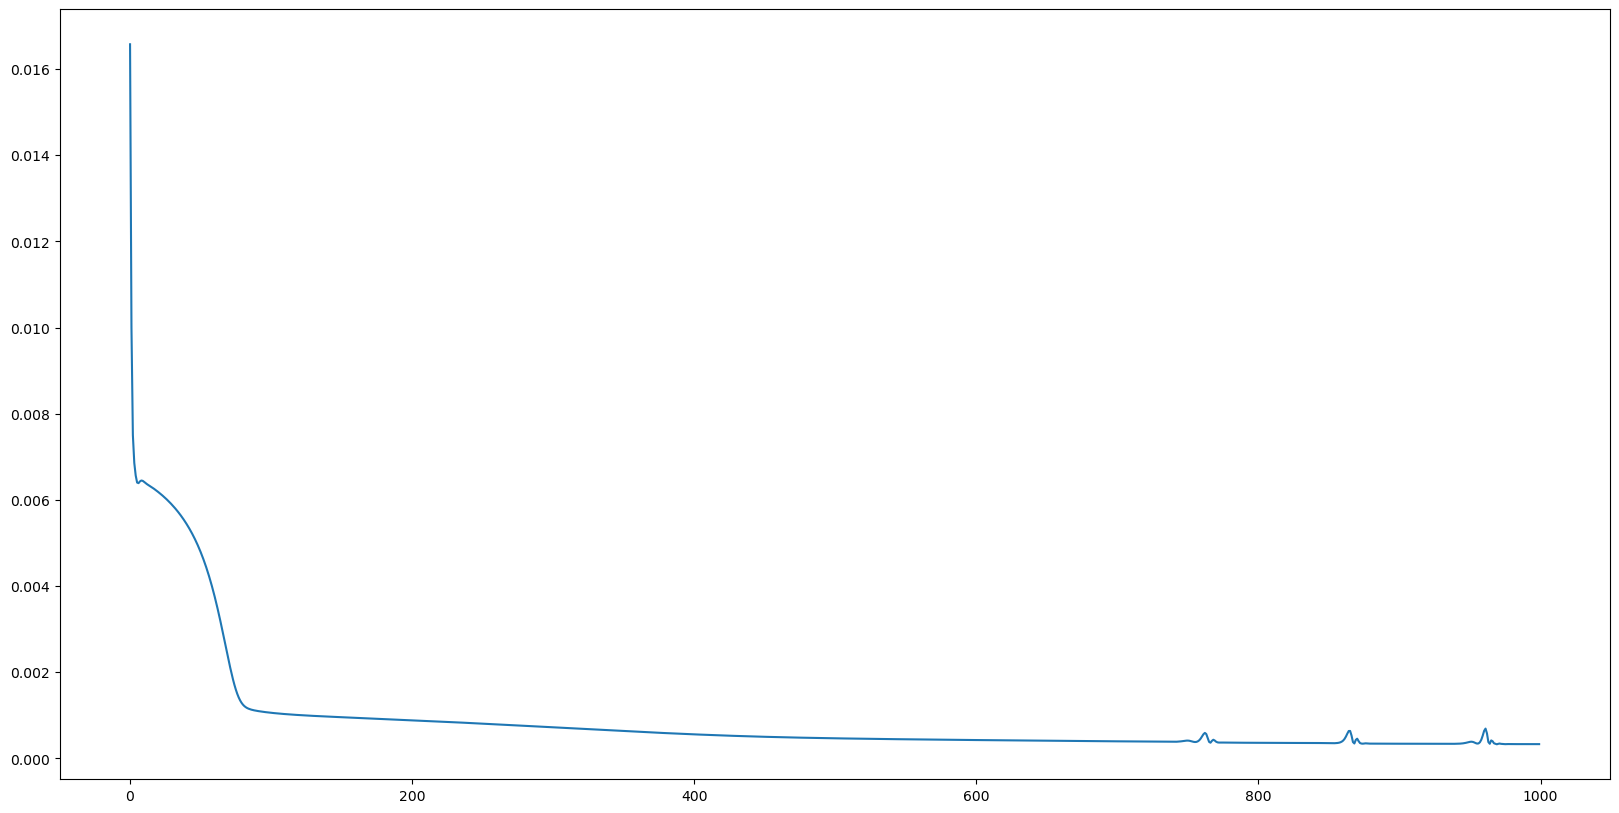

In [110]:
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

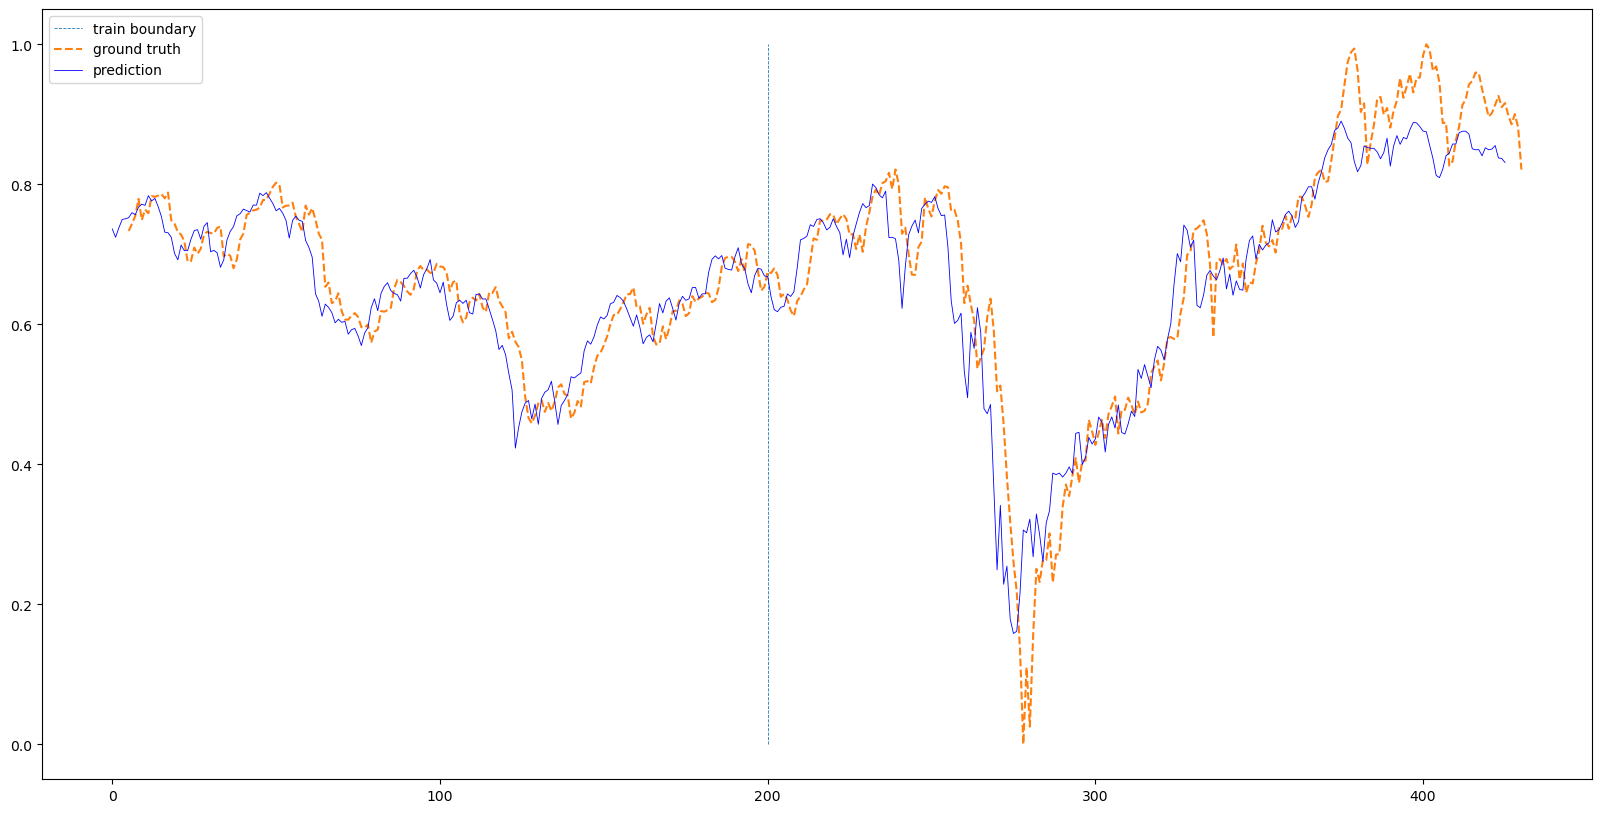

In [116]:
def plotting(train_loader, test_loader, actual):
    with torch.no_grad():
        train_pred = []
        test_pred = []
        
        for data in train_loader:
            seq, target = data
            out = model(seq)
            train_pred += out.numpy().tolist()
            
        for data in test_loader:
            seq, target = data
            out = model(seq)
            test_pred += out.numpy().tolist()
        
        total = train_pred + test_pred
        plt.figure(figsize=(20, 10))
        plt.plot(np.ones(100)*len(train_pred), np.linspace(0, 1, 100), '--', linewidth=0.6)
        plt.plot(actual, '--')
        plt.plot(total, 'b', linewidth = 0.6)
        
        plt.legend(['train boundary', 'ground truth', 'prediction'])
        plt.show()
        
plotting(train_loader, test_loader, df['Close'][seq_len:])